Part of the code in this notebook is from Germano Gabbianelli: https://github.com/tyrion/primal-dual-exercise/blob/master/Primal_Dual_Solutions.ipynb

License: GNU GPL v3

## Import the required dependencies

In [350]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib.ticker import ScalarFormatter
import gymnasium as gym
from gymnasium.envs.toy_text.frozen_lake import generate_random_map
import torch
from torch import nn
from torch.optim import Adam
import torch.functional as F
from functools import cached_property
from copy import deepcopy
import random
import torch.optim as optim

## Configure the Random number Generators

We set an initial seed to ensure reproducibility

In [351]:
RANDOM_SEED = 666
seed_seq = np.random.SeedSequence(RANDOM_SEED)
MAP_SEED, ENV_SEED, ALG_SEED = seed_seq.spawn(3)
MAP_SEED = int(MAP_SEED.generate_state(1)[0])
ENV_SEED = int(ENV_SEED.generate_state(1)[0])
M = MAP_SIZE = 5
FROZEN_PROBABILITY=0.9

random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

map = generate_random_map(
    size=MAP_SIZE,
    p=FROZEN_PROBABILITY,
    seed=ENV_SEED,
)

env = gym.make(
    "FrozenLake-v1",
    is_slippery=False,
    render_mode="rgb_array",
    desc=map,
)

env.reset(seed=ENV_SEED) # set the random seed
env_image = env.render()

## Define an Interface for our Algorithms

In [352]:
import abc

class Algorithm(abc.ABC):

    def __init__(self, env, df=0.95, seed=None):
        self.env = env
        self.df = df
        
        # useful as a shortcut
        self.S = env.observation_space.n
        self.A = env.action_space.n

        # initialize the random number generator
        self.rng = np.random.default_rng(seed)


    def step(self, t):
        raise NotImplementedError


We also define some utility functions/classes (hidden by default)

In [353]:
import numpy as np
import matplotlib.pyplot as plt

def plot_policy_with_heatmap(policy, value_function):
    # Compute U and V components for the quiver plot
    U = (policy[:, 2] - policy[:, 0]).reshape(M, M)
    V = (policy[:, 3] - policy[:, 1]).reshape(M, M)
    
    # Reshape the value function to match the grid
    heatmap_values = value_function.reshape(M, M)
    
    # Create the meshgrid for plotting
    x = np.arange(M) + 0.5
    X, Y = np.meshgrid(x, x[::-1])

    # Create the figure and axis
    fig, ax = plt.subplots()

    # Plot the heatmap
    cax = ax.imshow(heatmap_values, cmap='gray', extent=[0, M, 0, M])
    fig.colorbar(cax, ax=ax, orientation='vertical')

    # Overlay the environment image if provided
    if env_image is not None:
        ax.imshow(env_image, extent=[0, M, 0, M], alpha=0.5)

    # Plot the policy using quiver
    ax.quiver(X, Y, U, V, angles='xy', scale_units='xy', scale=2, color='red')

    # Set axis limits and aspect ratio
    ax.set(xlim=[0, M], ylim=[0, M], aspect='equal')

    # Show the plot
    plt.show()


In [354]:
## Utility functions/classes

def plot_policy(policy):

    U = (policy[:, 2] - policy[:, 0]).reshape(M, M)
    V = (policy[:, 3] - policy[:, 1]).reshape(M, M)

    x = np.arange(M) + 0.5
    X, Y = np.meshgrid(x, x[::-1])

    #U = np.ones(25).reshape(5,5)
    #V = U

    fig, ax = plt.subplots()


    ax.imshow(env_image, extent=[0, M, 0, M])

    ax.quiver(X, Y, U,V, angles='xy', scale_units='xy', scale=2)
    ax.set(xlim=[0,M], ylim=[0,M], aspect="equal")

    plt.show()

    
def compute_P(env):
    S = env.observation_space.n
    A = env.action_space.n

    P = P = np.zeros((S, A, S))

    for (state, state_data) in env.P.items():
        for (action, next_data) in state_data.items():
            for (prob, next_state, reward, terminated) in next_data:
                P[state, action, next_state] = prob

    return P


def compute_R(env):
    S = env.observation_space.n
    A = env.action_space.n

    R = np.zeros((S, A, S))

    for (state, state_data) in env.P.items():
        for (action, next_data) in state_data.items():
            for (prob, next_state, reward, terminated) in next_data:
                R[state, action, next_state] = reward

    return R


class InvalidatePolicy:
    def __set_name__(self, owner, name):
        self.name = name

    def __set__(self, instance, value):
        instance.__dict__[self.name] = value
        instance.__dict__.pop("policy", None)

## Linear Programming Formulation 

The Reinforcement Learning Problem can be formulated with the following two linear programs:

$\newcommand{\One}[1]{1\!\!1\{#1\}}$
$$
    \begin{aligned}[c]
        & \max_{\mu\succeq 0}\; \langle \mu, r \rangle \\
        & \textrm{subject to}\ E^\intercal \mu =(1-\gamma)\nu_0 + \gamma P^\intercal \mu \\
    \end{aligned}\quad\;\;
    \begin{aligned}[c]
    &\min_{v}\; (1-\gamma) \langle \nu_0, v\rangle \\
    &\textrm{subject to}\ Ev \geq r+\gamma Pv,
    \end{aligned}
$$

From which we can derive the Lagrangian

$$
\begin{aligned}
\mathcal{L}(v, \mu) &= (1-\gamma)\langle\nu_0, v\rangle + \langle\mu, r+\gamma Pv - Ev\rangle \\
 &= \langle\mu, r \rangle + \langle v, (1-\gamma)\nu_0 + \gamma P^\intercal \mu - E^\intercal \mu \rangle .
\end{aligned}
$$

We then use the gradients of the Lagrangian as losses for two alternativing mirror descent / ascent instances

$$
\begin{aligned}
\nabla_\mu \mathcal{L}(v, \mu) &= r+\gamma Pv - Ev\\
\nabla_v \mathcal{L}(v, \mu) &= (1-\gamma)\nu_0 + \gamma P^\intercal \mu - E^\intercal \mu
\end{aligned}
$$

<!--
Now consider the random variable $W=(X_0, X, A, R, X')$, where $X_0\sim \nu_0$,
$(X,A)\sim\mu$, $R=r(X,A)$, and $X'\sim p(\cdot\mid X,A)$. Then, we can define
the unbiased estimators

*   $\hat{\nu}_0(x) = \One{X^0=x}$,
*   $\hat{r}(x,a)= \One{X=x, A=a}R$
*   $\hat{p}(x'\mid x,a)=\One{X'=x'\mid X=x, A=a}$ -->

## A base class for our Tabular algorithms

In [355]:
from functools import cached_property

class TabularBase(Algorithm):

    # Makes sure the policy is deleted every time mu_sum is assigned
    mu_sum = InvalidatePolicy()

    def __init__(self, env, **kwds):
        lr_v = lr_mu = kwds.pop("lr", 0.01)
        self.lr_v = kwds.pop("lr_v", lr_v)
        self.lr_mu = kwds.pop("lr_mu", lr_mu)
        
        super().__init__(env, **kwds)

        # initialize variables
        self.v = np.zeros(self.S)
        self.mu = np.ones((self.S, self.A)) / (self.S * self.A)
        self.mu_sum = self.mu


    # @cached_property computes the attribute on first access and then caches it
    @cached_property
    def P(self):
        return compute_P(self.env)

    @cached_property
    def r(self):
        R = compute_R(self.env)
        return (self.P * R).sum(2)

    @property
    def nu0(self):
        return self.env.initial_state_distrib

    @cached_property
    def policy(self):
        return self.mu_sum / self.mu_sum.sum(1).reshape(-1, 1)


In [356]:
class LoggingMixin:
    "Utility class which evaluates the current policy at each step\
     and saves the values in `_rewards`."
    
    def __init__(self, env, *args, log_every=10, **kwds):
        super().__init__(env, *args, **kwds)

        self._log_every = log_every
        self._I = np.eye(self.S)
        self._rewards = []

    def evaluate_policy(self, policy):
        mean_return = []
        for i in range(10):
            next_s, _ = self.env.reset()
            done = False

            while not done:
                action = self.rng.choice(self.A, p=policy[next_s])
                next_s, r, terminations, truncations, infos = env.step(action)
                done = np.logical_or(terminations, truncations)
            mean_return.append(r)
        return np.mean(mean_return)

    def step(self, t):
        super().step(t)

        if t % self._log_every == 0:
            r = self.evaluate_policy(self.policy)
            self._rewards.append(r)

## Tabular Primal Dual with Generative Model

If $X$ and $A$ are sampled from the uniform distribution over the state-action space. Then,

$$
\newcommand{\S}{\mathcal{S}}
\newcommand{\A}{\mathcal{A}}
\nabla_\mu \mathcal{L}(v, \mu) = |\S||\A|\cdot \mathbb{E}[ r(X,A) + \gamma v(X') - v(X) ]
$$

If $X$ and $A$ are sampled according to $\mu$. Then,

$$
\nabla_v \mathcal{L}(v, \mu)_x = \mathbb{E}[ \One{X^0 = x} + \gamma \One{X' = x} - \One{X = x} ]
$$

In [357]:
SampleDT = [(x, int) for x in ["s0", "s", "a", "r", "next_s"]]


def collect_sample(env, s, a):
    s0 = env.s
    
    env.unwrapped.s = s # the hours I spent before I realized I had to put `unwrapped` here. You have no idea.
    next_s, r, *_ = env.step(a)
    
    return np.rec.array((s0, s, a, r, next_s), dtype=SampleDT)


class GenerativePD(TabularBase):


    def sample_action(self, state):
        p = self.mu[state]
        return self.rng.choice(self.A, p = p / p.sum())

    def sample_state(self):
        return self.rng.choice(self.S, p = self.mu.sum(1))
    
    def step_v(self):
        grad = self.grad_v(self.mu)

        v = self.v - self.lr_v * grad

        v_min = 0
        v_max = 1/(1-self.df)
        return np.clip(v, v_min, v_max)


    def step_mu(self):
        grad = self.grad_mu(self.v)

        p = self.mu * np.exp(self.lr_mu * grad)
        mu = p / p.sum()
        return mu

    def grad_mu(self, v):
        w = self.sample

        grad = np.zeros((self.S, self.A))
        grad[w.s, w.a] = (w.r + self.df * v[w.next_s] - v[w.s]) * self.S * self.A #/ self.mu[w.s, w.a] #
        return grad

    def grad_v(self, mu):
        w = self.sample

        grad = np.zeros(self.S)
        grad[w.s0] = (1 - self.df)
        grad[w.next_s] += self.df
        grad[w.s] -= 1
        #grad -= mu.sum(1)
        #grad[w.next_s] += self.df * mu[w.s, w.a] - mu[w.next_s].sum()
        return grad


    def step(self, t):  
        # update for mu
        s = self.rng.choice(self.S)
        a = self.rng.choice(self.A) 
        self.sample = collect_sample(self.env, s, a)
        
        mu = self.step_mu()
        
        # reset the env to get a fresh sample from the initial distrib
        self.env.reset()
        
        # update for v
        s = self.sample_state()
        a = self.sample_action(s)
        self.sample = collect_sample(self.env, s, a)

        v = self.step_v()

        
        # set the variables
        self.v = v
        self.mu = mu
        self.mu_sum += mu


class LoggingGenerativePD(LoggingMixin, GenerativePD):
    pass

In [358]:
n = 500000 # 40_000
lr = 0.0031

agent = LoggingGenerativePD(
    env,
    lr_v = lr,
    lr_mu = lr / 3,
    log_every = 1000,
    seed = ALG_SEED
)
for t in range(1, n):
    agent.step(t)

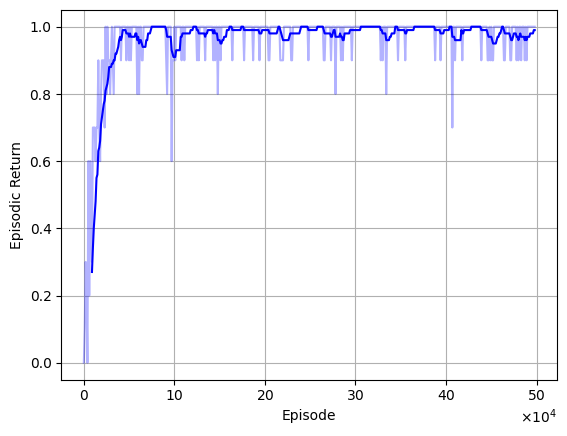

In [359]:

smoothed = pd.Series(agent._rewards).rolling(window=10, center=False).mean()

fig, ax = plt.subplots()

ax.plot(range(0, len(agent._rewards)*1000, 1000), agent._rewards, alpha=0.3, color="blue")
ax.plot(range(0, len(smoothed)*1000, 1000), smoothed, color="blue")

ax.grid()
ax.set_xlabel("Episode")
ax.set_ylabel("Episodic Return")
ax.xaxis.set_major_formatter(ScalarFormatter(useMathText=True))
ax.ticklabel_format(style='sci', axis='x', scilimits=(4, 4))

plt.show()


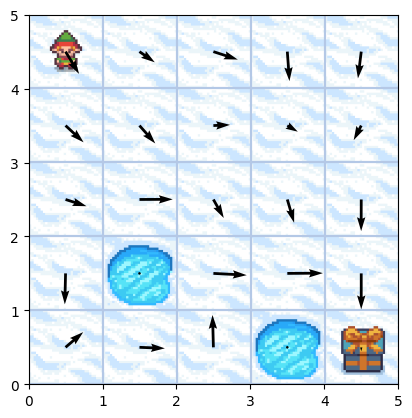

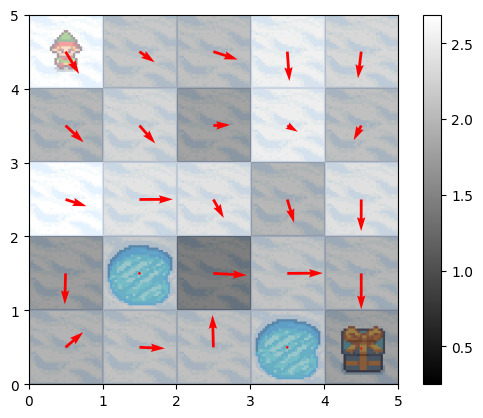

In [360]:
plot_policy(agent.policy)
plot_policy_with_heatmap(agent.policy, agent.v)

## Q-Function

In [366]:
class LoggingMixin:
    "Utility class which evaluates the current policy at each step\
     and saves the values in `_rewards`."
    
    def __init__(self, env, *args, log_every=10, **kwds):
        super().__init__(env, *args, **kwds)

        self._log_every = log_every
        self._I = np.eye(self.S)
        self._rewards = []

    def evaluate_policy(self, policy):
        mean_return = []
        for i in range(10):
            next_s, _ = self.env.reset()
            done = False

            while not done:
                action = self.rng.choice(self.A, p=policy[next_s])
                next_s, r, terminations, truncations, infos = env.step(action)
                done = np.logical_or(terminations, truncations)
            mean_return.append(r)
        return np.mean(mean_return)

    def step(self, t):
        super().step(t)

        if t % self._log_every == 0:
            r = self.evaluate_policy(self.policy)
            self._rewards.append(r)

In [367]:
from functools import cached_property


class TabularBase(Algorithm):

    # Makes sure the policy is deleted every time mu_sum is assigned
    mu_sum = InvalidatePolicy()

    def __init__(self, env, **kwds):
        lr_q = lr_mu = kwds.pop("lr", 0.01)
        self.lr_q = kwds.pop("lr_q", lr_q)
        self.lr_mu = kwds.pop("lr_mu", lr_mu)
        
        super().__init__(env, **kwds)

        # initialize variables
        self.q = np.full((self.S, self.A), 0)
        self.mu = np.ones((self.S, self.A)) / (self.S * self.A)
        self.mu_sum = self.mu


    # @cached_property computes the attribute on first access and then caches it
    @cached_property
    def P(self):
        return compute_P(self.env)

    @cached_property
    def r(self):
        R = compute_R(self.env)
        return (self.P * R).sum(2)

    @property
    def nu0(self):
        return self.env.initial_state_distrib

    @cached_property
    def policy(self):
        return self.mu_sum / self.mu_sum.sum(1).reshape(-1, 1)

In [368]:
SampleDT = [(x, int) for x in ["s0", "s", "a", "r", "next_s"]]


def collect_sample(env, s, a):
    s0 = env.s
    
    env.unwrapped.s = s # the hours I spent before I realized I had to put `unwrapped` here. You have no idea.
    next_s, r, *_ = env.step(a)
    
    return np.rec.array((s0, s, a, r, next_s), dtype=SampleDT)


class GenerativePD(TabularBase):

    def sample_action(self, state):
        p = self.mu[state]
        return self.rng.choice(self.A, p = p / p.sum())

    def sample_state(self):
        return self.rng.choice(self.S, p = self.mu.sum(1))
    
    def grad_mu(self, q):
        w = self.sample
        grad = np.zeros((self.S, self.A))
        v = np.sum(self.policy[w.next_s] * q[w.next_s])
        grad[w.s, w.a] = (w.r + self.df * v - q[w.s, w.a]) * self.S * self.A 
        return grad

    def grad_q(self, mu):
        w = self.sample
        grad = np.zeros((self.S, self.A))
        first_action = self.policy[w.s0].argmax()
        # first_action = self.rng.choice(self.A, p = self.policy[w.s0])
        next_a = self.policy[w.next_s].argmax()
        # next_a = self.rng.choice(self.A, p = self.policy[w.next_s])

        grad[w.s0, first_action] = (1 - self.df)
        grad[w.s, w.a] -= 1 
        grad[w.next_s, next_a] += self.df 

        return grad
    
    def step_q(self):
        grad = self.grad_q(self.mu)
        q = self.q - self.lr_q * grad

        q_min = 0
        q_max = 1/(1-self.df)
        return np.clip(q, q_min, q_max)
    
    def step_mu(self):
        grad = self.grad_mu(self.q)

        p = self.mu * np.exp(self.lr_mu * grad)
        mu = p / p.sum()
        return mu

    def step(self, t):  
        s = self.rng.choice(self.S)
        a = self.rng.choice(self.A) 
        self.sample = collect_sample(self.env, s, a)

        mu = self.step_mu()

        self.env.reset()
        s = self.sample_state()
        a = self.sample_action(s)
        self.sample = collect_sample(self.env, s, a)

        q = self.step_q()

        self.q = q
        self.mu = mu
        self.mu_sum += mu


class LoggingGenerativePD(LoggingMixin, GenerativePD):
    pass

In [371]:
n = 500000
lr_q = 0.003
lr_mu = 0.001
agent = LoggingGenerativePD(
    env,
    lr_q = lr_q,
    lr_mu = lr_mu,
    log_every = 1000,
    seed = ALG_SEED
)
for t in range(1, n):
    agent.step(t)

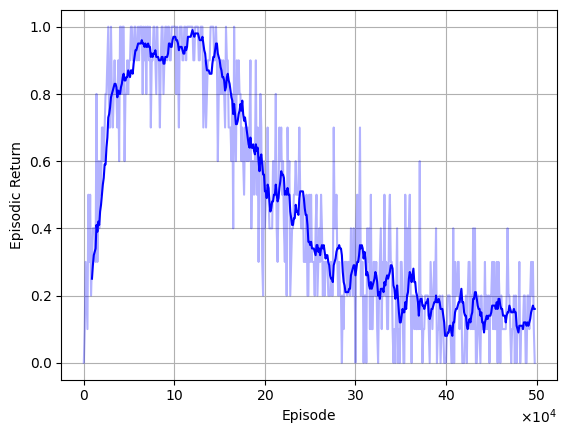

In [372]:
smoothed = pd.Series(agent._rewards).rolling(window=10, center=False).mean()

fig, ax = plt.subplots()

ax.plot(range(0, len(agent._rewards)*1000, 1000), agent._rewards, alpha=0.3, color="blue")
ax.plot(range(0, len(smoothed)*1000, 1000), smoothed, color="blue")

ax.grid()
ax.set_xlabel("Episode")
ax.set_ylabel("Episodic Return")
ax.xaxis.set_major_formatter(ScalarFormatter(useMathText=True))
ax.ticklabel_format(style='sci', axis='x', scilimits=(4, 4))

plt.show()

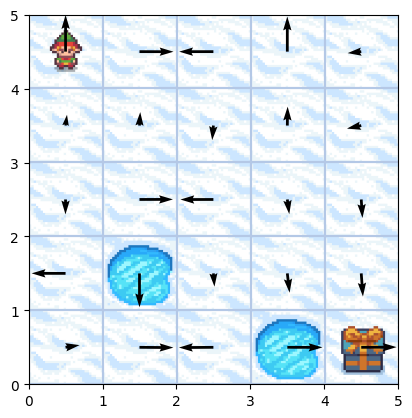

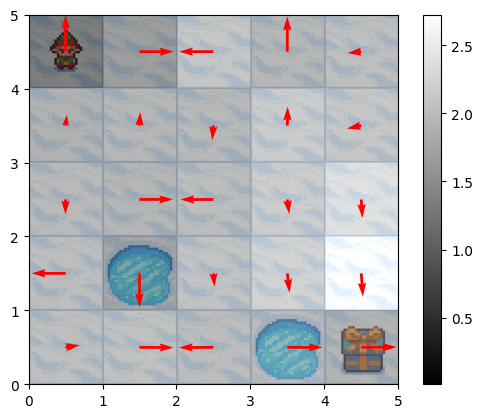

In [365]:
plot_policy(agent.policy)
v = np.sum(agent.policy * agent.q, axis=1)
plot_policy_with_heatmap(agent.policy, v)

## MinMax Dual

In [379]:
class LoggingMixin:
    "Utility class which evaluates the current policy at each step\
     and saves the values in `_rewards`."
    
    def __init__(self, env, *args, log_every=10, **kwds):
        super().__init__(env, *args, **kwds)

        self._log_every = log_every
        self._I = np.eye(self.S)
        self._rewards = []

    def evaluate_policy(self, policy):
        mean_return = []
        for i in range(10):
            next_s, _ = self.env.reset()
            done = False

            while not done:
                action = self.rng.choice(self.A, p=policy[next_s])
                next_s, r, terminations, truncations, infos = env.step(action)
                done = np.logical_or(terminations, truncations)
            mean_return.append(r)
        return np.mean(mean_return)

    def step(self, t, K, optimizer):
        super().step(t, K, optimizer)

        if t % self._log_every == 0:
            r = self.evaluate_policy(self.policy)
            self._rewards.append(r)
            print(f"Step {t}: {r}")

        if t == (self.total_timesteps):
            r = self.evaluate_policy(self.policy)
            print(f"Step {t}: {r}")
            return r

In [339]:
def one_hot_encode(tensor, num_classes=25):
    one_hot = torch.zeros(tensor.size(0),  num_classes)
    one_hot = one_hot.scatter_(1, tensor.long().unsqueeze(-1), 1)
    return one_hot

def softmax(matrix, axis=1):
    max_val = np.max(matrix, axis=axis, keepdims=True)
    shifted_matrix = matrix - max_val
    exp_matrix = np.exp(shifted_matrix)
    sum_exp = np.sum(exp_matrix, axis=axis, keepdims=True)
    softmax_matrix = exp_matrix / sum_exp

    return softmax_matrix

class QNetwork(nn.Module):
    def __init__(self, env, args):
        super().__init__()
        self.env = env
        self.critic = nn.Sequential(
            nn.Linear(M*M, 128),
            nn.ReLU(),
            nn.Linear(128, env.action_space.n),
        )

    def forward(self, x):
        x = one_hot_encode(x)
        q = self.critic(x)
        q = torch.clamp(q, 0, 1/(1-self.df))
        return q
    
    def get_values(self, x, policy):
        q = self(x)
        probs = torch.Tensor(policy[x])
        v = torch.sum(probs * q, dim=1).squeeze(-1)
        return q, v

In [376]:
class TabularBase(Algorithm):
    policy_sum = InvalidatePolicy()

    def __init__(self, env, **kwds):
        lr_q = lr_z = temp = kwds.pop("lr", 0.01)
        self.lr_q = kwds.pop("lr_q", lr_q)
        self.lr_z = kwds.pop("lr_z", lr_z)
        self.temp = kwds.pop("temp", temp)
        self.reg_coef = kwds.pop("reg_coef", 1)
        self.tabular = kwds.pop("tabular", True)
        self.N = kwds.pop("N", 25)
        self.total_timesteps = kwds.pop("total_timesteps", 100000)
        self.sampling_strategy = kwds.pop("sampling_strategy", "reset")
        self.average_critic = kwds.pop("average_critic", False)
        
        super().__init__(env, **kwds)


        if self.tabular:
            self.q = np.full((self.S, self.A), 0)

        else:
            self.q = QNetwork(env, self)
        self.policy = np.ones((self.S, self.A)) / (self.A)
        self.policy_sum = self.policy
        self.z = np.full((self.N), 1)

    @cached_property
    def P(self):
        return compute_P(self.env)

    @cached_property
    def r(self):
        R = compute_R(self.env)
        return (self.P * R).sum(2)

    @property
    def nu0(self):
        return self.env.initial_state_distrib
    
    @cached_property
    def policy(self):
        return self.policy_sum / self.policy_sum.sum(1)[:, np.newaxis]
    
    def reset_z(self):
        self.z = np.full((self.N), 1)

In [380]:
SampleDT = [(x, int) for x in ["s0", "s", "a", "r", "next_s"]]


def collect_sample(env, s, a, agent):
    s0 = env.s
    
    env.unwrapped.s = s
    next_s, r, terminations, truncations, infos = env.step(a)
    next_done = np.logical_or(terminations, truncations)
    if next_done:
        if agent.sampling_strategy == "reset":
            next_s, _ = agent.env.reset()
        elif agent.sampling_strategy == "random":
            next_s = agent.rng.choice(agent.S)
        elif agent.sampling_strategy == "sample":
            next_s = agent.sample_state()
    
    return np.rec.array((s0, s, a, r, next_s), dtype=SampleDT), next_s


class GenerativePD(TabularBase):

    def sample_action(self, state):
        p = self.policy[state]
        return self.rng.choice(self.A, p = p)
    
    def sample_state(self):
        if self.tabular:
            state_dist = np.sum(self.policy * self.q, axis=1)
            state_dist /= state_dist.sum()
        else:
            state_dist = np.sum(self.policy * self.q(torch.arange(self.S)).detach().numpy(), axis=1)
            state_dist /= state_dist.sum()

        return self.rng.choice(self.S, p = state_dist)


    def grad_z(self, q, batch_transitions):
        if self.tabular:
            s = np.array([w.s for w in batch_transitions])
            a = np.array([w.a for w in batch_transitions])
            next_s = np.array([w.next_s for w in batch_transitions])
            r = np.array([w.r for w in batch_transitions])

            value_next_s = np.sum(self.policy * q, axis=1)
            v = value_next_s[next_s]
            grad = (r + self.df * v - q[s, a]) - self.reg_coef * np.log(self.z)

            return grad
        else:
            grad = torch.zeros(self.N)
            states = torch.tensor([int(w.s) for w in batch_transitions])
            next_states = torch.tensor([int(w.next_s) for w in batch_transitions])
            rewards = torch.tensor([float(w.r) for w in batch_transitions])
            actions = torch.tensor([int(w.a) for w in batch_transitions])
            z_values = torch.tensor([float(z) for z in self.z])

            q_values, v_values = self.q.get_values(states, self.policy)
            q_selected = q_values.gather(-1, actions.unsqueeze(-1)).squeeze(-1).detach().numpy()
            v_next_values = self.q.get_values(next_states, self.policy)[1].detach().numpy()

            errors = (rewards + self.df * v_next_values - q_selected) - self.reg_coef * np.log(z_values)
            grad += errors

            return grad.numpy()
    
    def grad_q(self, z, batch_transitions):
        s0 = np.array([w.s0 for w in batch_transitions])
        s = np.array([w.s for w in batch_transitions])
        a = np.array([w.a for w in batch_transitions])
        next_s = np.array([w.next_s for w in batch_transitions])
        z = np.array([self.z[i] for i, _ in enumerate(batch_transitions)])

        grad = np.zeros((self.S, self.A))

        first_action = np.array([self.policy[s0_i].argmax() for s0_i in s0])
        next_a = np.array([self.policy[next_s_i].argmax() for next_s_i in next_s])

        np.add.at(grad, (s0, first_action), (1 - self.df))
        np.add.at(grad, (s, a), -z)
        np.add.at(grad, (next_s, next_a), self.df * z)

        return grad
    
    def step_q(self, batch_transitions, optimizer):
        if self.tabular:
            grad = self.grad_q(self.z, batch_transitions)
            q = self.q - self.lr_q * grad / self.N
            q_min = 0
            q_max = 1/(1-self.df)
            self.q = np.clip(q, q_min, q_max) 
        else:
            states = torch.tensor([int(w.s) for w in batch_transitions])
            next_states = torch.tensor([int(w.next_s) for w in batch_transitions])
            rewards = torch.tensor([float(w.r) for w in batch_transitions])
            actions = torch.tensor([int(w.a) for w in batch_transitions])
            z_values = torch.tensor([float(z) for z in self.z])

            q_values, v_values = self.q.get_values(states, self.policy)
            q_selected = q_values.gather(-1, actions.unsqueeze(-1)).squeeze(-1)
            v_next_values = self.q.get_values(next_states, self.policy)[1]
            target_values = rewards + self.df * v_next_values

            error = torch.mean(z_values * (target_values - q_selected)  + (1 - self.df) * v_values) #- self.reg_coef * (z_values * torch.log(z_values) - z_values)

            optimizer.zero_grad()
            error.backward()
            optimizer.step()
    
    def step_z(self, batch_transitions):
        grad = self.grad_z(self.q, batch_transitions)
        z = self.z * np.exp(self.lr_z * grad / self.N)
        return z
    
    def step_policy(self, q):
        if self.tabular:
            q_values = self.q
            update = softmax(q_values * self.temp)
            policy_probs =  self.policy * update
            policy = policy_probs / policy_probs.sum(1)[:, np.newaxis]
            return policy
        else:
            q_values = self.q(torch.arange(self.S)).detach()
            update = F.softmax(q_values * self.temp, dim=1).numpy()
            policy_probs = self.policy * update
            policy = policy_probs / policy_probs.sum(1)[:, np.newaxis]
            return policy
    
    def step(self, t, K, optimizer):  
        batch_transitions = []

        if self.sampling_strategy == "reset":
            next_obs, _ = self.env.reset()
        elif self.sampling_strategy == "random":
            next_obs = self.rng.choice(self.S)
        elif self.sampling_strategy == "sample":
            next_obs = self.sample_state()

        for t in range(self.N):
            a = self.sample_action(next_obs)
            self.sample, next_obs = collect_sample(self.env, next_obs, a, self)
            batch_transitions.append(self.sample)

        weights_after_each_epoch = []
        q_sum = np.zeros((self.S, self.A))

        for k in range(K):
            self.step_q(batch_transitions, optimizer)
            self.z = self.step_z(batch_transitions)
            if self.tabular:
                q_sum += self.q
            else:
                weights_after_each_epoch.append({key: val.cpu().numpy() for key, val in self.q.state_dict().items()})

        if self.average_critic:
            if self.tabular:
                self.q = q_sum / K
            else:
                avg_weights = {}
                for key in weights_after_each_epoch[0].keys():
                    avg_weights[key] = np.mean([T[key] for T in weights_after_each_epoch], axis=0)
                self.q.load_state_dict({key: torch.tensor(val) for key, val in avg_weights.items()})

        self.policy = self.step_policy(self.q)
        self.policy_sum = self.policy
        self.reset_z()


class LoggingGenerativePD(LoggingMixin, GenerativePD):
    pass

Total timesteps:  50000
Step 1000: 1.0
Step 2000: 1.0
Step 3000: 1.0
Step 4000: 1.0
Step 5000: 1.0
Step 6000: 1.0
Step 7000: 1.0
Step 8000: 1.0
Step 9000: 1.0
Step 10000: 1.0
Step 11000: 1.0
Step 12000: 1.0
Step 13000: 1.0
Step 14000: 1.0
Step 15000: 1.0
Step 16000: 1.0
Step 17000: 1.0
Step 18000: 1.0
Step 19000: 1.0
Step 20000: 1.0
Step 21000: 1.0
Step 22000: 1.0
Step 23000: 1.0
Step 24000: 1.0
Step 25000: 1.0
Step 26000: 1.0
Step 27000: 1.0
Step 28000: 1.0
Step 29000: 1.0
Step 30000: 1.0
Step 31000: 1.0
Step 32000: 1.0
Step 33000: 1.0
Step 34000: 1.0
Step 35000: 1.0
Step 36000: 1.0
Step 37000: 1.0
Step 38000: 1.0
Step 39000: 1.0
Step 40000: 1.0
Step 41000: 1.0
Step 42000: 1.0
Step 43000: 1.0
Step 44000: 1.0
Step 45000: 1.0
Step 46000: 1.0
Step 47000: 1.0
Step 48000: 1.0
Step 49000: 1.0
Step 50000: 1.0
Step 50000: 1.0
Rewards saved to rewards_pol_eval_0.csv


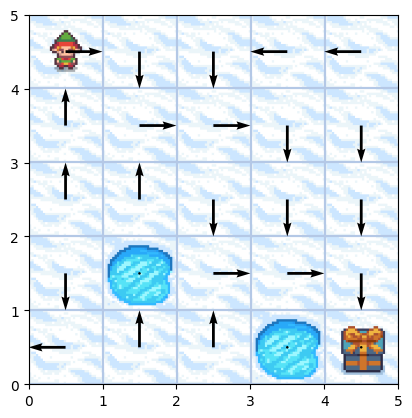

In [385]:
import csv


total_timesteps = 50000
K = 15
lr_q = 0.13871091091091092
lr_z = 0.47197757757757763
temp = 0.6154545454545455
reg_coef = 1.254994994994995
N = 60
tabular = True
total_timesteps = total_timesteps
sampling_strategy = "reset"
average_critic = False
anneal_lr = False

agent = LoggingGenerativePD(
    env,
    lr_q = lr_q,
    lr_z = lr_z,
    log_every = 1000,
    reg_coef = reg_coef,
    temp = temp,
    tabular = tabular,
    sampling_strategy = sampling_strategy,
    average_critic = average_critic,
    N = N,
    total_timesteps = total_timesteps,
    seed = ALG_SEED
)

if agent.tabular:
    optimizer = None

else:
    optimizer = getattr(optim, "Adam")(
            list(agent.q.parameters()), lr=lr_q
        )
print("Total timesteps: ", total_timesteps)
for t in range(1, total_timesteps + 1):
    if anneal_lr:
        frac = 1.0 - (t - 1.0) / total_timesteps
        if tabular:
            agent.lr_q = frac * lr_q
        else:
            lrnow = frac * lr_q
            optimizer.param_groups[0]["lr_q"] = lrnow

    r = agent.step(t, K, optimizer)

# Save agent._rewards list as a CSV file
rewards = agent._rewards
csv_file = f'rewards_pol_eval_0.csv'
with open(csv_file, 'w') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(["Step", "Reward"])
    for step, reward in enumerate(rewards):
        writer.writerow([step+1, reward])
print(f"Rewards saved to {csv_file}")

plot_policy(agent.policy)


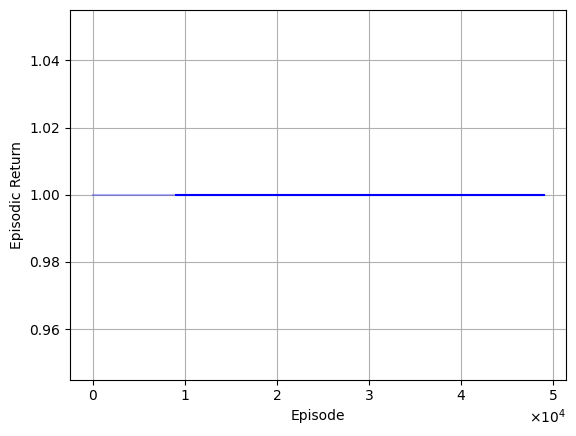

In [348]:
smoothed = pd.Series(agent._rewards).rolling(window=10, center=False).mean()

fig, ax = plt.subplots()

ax.plot(range(0, len(agent._rewards)*1000, 1000), agent._rewards, alpha=0.3, color="blue")
ax.plot(range(0, len(smoothed)*1000, 1000), smoothed, color="blue")

ax.grid()
ax.set_xlabel("Episode")
ax.set_ylabel("Episodic Return")
ax.xaxis.set_major_formatter(ScalarFormatter(useMathText=True))
ax.ticklabel_format(style='sci', axis='x', scilimits=(4, 4))

plt.show()

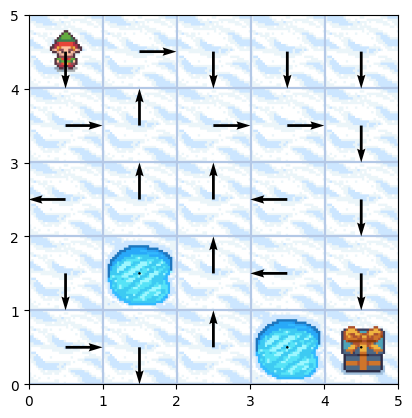

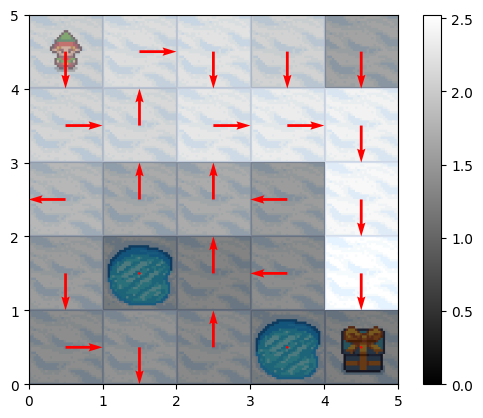

In [349]:
plot_policy(agent.policy)
v = np.sum(agent.policy * agent.q, axis=1)
plot_policy_with_heatmap(agent.policy, v)

## MinMax Q-REPS

In [232]:
class LoggingMixin:
    "Utility class which evaluates the current policy at each step\
     and saves the values in `_rewards`."
    
    def __init__(self, env, *args, log_every=10, **kwds):
        super().__init__(env, *args, **kwds)

        self._log_every = log_every
        self._I = np.eye(self.S)
        self._rewards = []

    def evaluate_policy(self, policy):
        mean_return = []
        for i in range(10):
            next_s, _ = self.env.reset()
            done = False

            while not done:
                action = self.rng.choice(self.A, p=policy[next_s])
                next_s, r, terminations, truncations, infos = env.step(action)
                done = np.logical_or(terminations, truncations)
            mean_return.append(r)
        return np.mean(mean_return)

    def step(self, t, K, optimizer):
        super().step(t, K, optimizer)

        if t % self._log_every == 0:
            r = self.evaluate_policy(self.policy)
            self._rewards.append(r)
            print(f"Step {t}: {r}")

        if t == (self.total_timesteps):
            r = self.evaluate_policy(self.policy)
            print(f"Step {t}: {r}")
            return r

In [474]:
def one_hot_encode(tensor, num_classes=25):
    one_hot = torch.zeros(tensor.size(0),  num_classes)
    one_hot = one_hot.scatter_(1, tensor.long().unsqueeze(-1), 1)
    return one_hot

def softmax(matrix, axis=1):
    max_val = np.max(matrix, axis=axis, keepdims=True)
    shifted_matrix = matrix - max_val
    exp_matrix = np.exp(shifted_matrix)
    sum_exp = np.sum(exp_matrix, axis=axis, keepdims=True)
    softmax_matrix = exp_matrix / sum_exp

    return softmax_matrix

In [233]:
class QNetwork(nn.Module):
    def __init__(self, env, args):
        super().__init__()
        self.env = env
        self.reg_coef = args.reg_coef
        self.df = args.df
        self.critic = nn.Sequential(
            nn.Linear(M*M, 128),
            nn.ReLU(),
            nn.Linear(128, env.action_space.n),
        )

    def forward(self, x):
        x = one_hot_encode(x)
        q = self.critic(x)
        q = torch.clamp(q, 0, 1/(1-self.df))
        return q
    
    def get_values(self, x, policy):
        q = self(x)
        probs = torch.Tensor(policy[x])
        v = self.reg_coef * torch.log(torch.sum(probs * torch.exp(q/self.reg_coef), dim=1).squeeze(-1))
        return q, v

In [234]:
from functools import cached_property

class TabularBase(Algorithm):
    policy_sum = InvalidatePolicy()

    def __init__(self, env, **kwds):
        lr_q = lr_z = temp = kwds.pop("lr", 0.01)
        self.lr_q = kwds.pop("lr_q", lr_q)
        self.lr_z = kwds.pop("lr_z", lr_z)
        self.temp = kwds.pop("temp", temp)
        self.reg_coef = kwds.pop("reg_coef", 0.1)
        self.tabular = kwds.pop("tabular", False)
        self.N = kwds.pop("N", 25)
        self.total_timesteps = kwds.pop("total_timesteps", 100000)
        self.sampling_strategy = kwds.pop("sampling_strategy", "reset")
        self.average_critic = kwds.pop("average_critic", False)
        
        super().__init__(env, **kwds)


        if self.tabular:
            self.q = np.full((self.S, self.A), 0)

        else:
            self.q = QNetwork(env, self)
        self.policy = np.ones((self.S, self.A)) / (self.A)
        self.policy_sum = self.policy
        self.z = np.full((self.N), 1) / self.N

    @cached_property
    def P(self):
        return compute_P(self.env)

    @cached_property
    def r(self):
        R = compute_R(self.env)
        return (self.P * R).sum(2)

    @property
    def nu0(self):
        return self.env.initial_state_distrib
    
    @cached_property
    def policy(self):
        return self.policy_sum / self.policy_sum.sum(1)[:, np.newaxis]
    
    def reset_z(self):
        self.z = np.full((self.N), 1) / self.N

In [242]:
SampleDT = [(x, int) for x in ["s0", "s", "a", "r", "next_s"]]


def collect_sample(env, s, a, agent):
    s0 = env.s
    
    env.unwrapped.s = s
    next_s, r, terminations, truncations, infos = env.step(a)
    next_done = np.logical_or(terminations, truncations)
    if next_done:
        if agent.sampling_strategy == "reset":
            next_s, _ = agent.env.reset()
        elif agent.sampling_strategy == "random":
            next_s = agent.rng.choice(agent.S)
        elif agent.sampling_strategy == "sample":
            next_s = agent.sample_state()
    
    return np.rec.array((s0, s, a, r, next_s), dtype=SampleDT), next_s


class GenerativePD(TabularBase):

    def sample_action(self, state):
        p = self.policy[state]
        return self.rng.choice(self.A, p = p)
    
    def sample_state(self):
        if self.tabular:
            state_dist = np.sum(self.policy * self.q, axis=1)
            state_dist /= state_dist.sum()
        else:
            state_dist = np.sum(self.policy * self.q(torch.arange(self.S)).detach().numpy(), axis=1)
            state_dist /= state_dist.sum()

        return self.rng.choice(self.S, p = state_dist)


    def grad_z(self, q, batch_transitions):
        if self.tabular:
            s = np.array([w.s for w in batch_transitions])
            a = np.array([w.a for w in batch_transitions])
            next_s = np.array([w.next_s for w in batch_transitions])
            r = np.array([w.r for w in batch_transitions])

            value_next_s = self.reg_coef* np.log(np.sum(self.policy * np.exp(q/self.reg_coef), axis=1))
            v = value_next_s[next_s]
            grad = (r + self.df * v - q[s, a]) - self.reg_coef * np.log(self.z)

            return grad
        else:
            grad = torch.zeros(self.N)
            states = torch.tensor([int(w.s) for w in batch_transitions])
            next_states = torch.tensor([int(w.next_s) for w in batch_transitions])
            rewards = torch.tensor([float(w.r) for w in batch_transitions])
            actions = torch.tensor([int(w.a) for w in batch_transitions])
            z_values = torch.tensor([float(z) for z in self.z])

            q_values, v_values = self.q.get_values(states, self.policy)
            q_selected = q_values.gather(-1, actions.unsqueeze(-1)).squeeze(-1).detach().numpy()
            v_next_values = self.q.get_values(next_states, self.policy)[1].detach().numpy()

            errors = (rewards + self.df * v_next_values - q_selected) - self.reg_coef * (np.log(z_values * self.N) + 1)
            grad += errors

            return grad.numpy()
    
    def grad_q(self, z, batch_transitions):
        s0 = np.array([w.s0 for w in batch_transitions])
        s = np.array([w.s for w in batch_transitions])
        a = np.array([w.a for w in batch_transitions])
        next_s = np.array([w.next_s for w in batch_transitions])
        z = np.array([self.z[i] for i, _ in enumerate(batch_transitions)])

        grad = np.zeros((self.S, self.A))

        first_action = np.array([self.policy[s0_i].argmax() for s0_i in s0])
        next_a = np.array([self.policy[next_s_i].argmax() for next_s_i in next_s])

        np.add.at(grad, (s0, first_action), (1 - self.df))
        np.add.at(grad, (s, a), -z)
        np.add.at(grad, (next_s, next_a), self.df * z)

        return grad

    
    def step_q(self, batch_transitions, optimizer):
        if self.tabular:
            grad = self.grad_q(self.z, batch_transitions)
            q = self.q - self.lr_q * grad / self.N
            q_min = 0
            q_max = 1/(1-self.df)
            self.q = np.clip(q, q_min, q_max) 
        else:
            states = torch.tensor([int(w.s) for w in batch_transitions])
            next_states = torch.tensor([int(w.next_s) for w in batch_transitions])
            rewards = torch.tensor([float(w.r) for w in batch_transitions])
            actions = torch.tensor([int(w.a) for w in batch_transitions])
            z_values = torch.tensor([float(z) for z in self.z])

            q_values, v_values = self.q.get_values(states, self.policy)
            q_selected = q_values.gather(-1, actions.unsqueeze(-1)).squeeze(-1)
            v_next_values = self.q.get_values(next_states, self.policy)[1]
            target_values = rewards + self.df * v_next_values

            error = torch.mean(z_values * (target_values - q_selected - self.reg_coef * torch.log(self.N*z_values))  + (1 - self.df) * v_values)

            optimizer.zero_grad()
            error.backward()
            optimizer.step()
    
    def step_z(self, batch_transitions):
        grad = self.grad_z(self.q, batch_transitions)
        z = self.z * np.exp(self.lr_z * grad / self.N)
        z = z / z.sum()
        return z
    
    def step_policy(self, q):
        if self.tabular:
            q_values = self.q
            update = np.exp(q_values / self.reg_coef)
            policy_probs =  self.policy * update
            policy = policy_probs / policy_probs.sum(1)[:, np.newaxis]
            return policy
        else:
            q_values = self.q(torch.arange(self.S)).detach()
            update = F.softmax(q_values / self.reg_coef, dim=1).numpy()
            policy_probs = self.policy * update
            policy = policy_probs / policy_probs.sum(1)[:, np.newaxis]
            return policy
    
    def step(self, t, K, optimizer):  
        batch_transitions = []

        if self.sampling_strategy == "reset":
            next_obs, _ = self.env.reset()
        elif self.sampling_strategy == "random":
            next_obs = self.rng.choice(self.S)
        elif self.sampling_strategy == "sample":
            next_obs = self.sample_state()

        for t in range(self.N):
            a = self.sample_action(next_obs)
            self.sample, next_obs = collect_sample(self.env, next_obs, a, self)
            batch_transitions.append(self.sample)

        weights_after_each_epoch = []
        q_sum = np.zeros((self.S, self.A))

        for k in range(K):
            self.step_q(batch_transitions, optimizer)
            self.z = self.step_z(batch_transitions)
            if self.tabular:
                q_sum += self.q
            else:
                weights_after_each_epoch.append({key: val.cpu().numpy() for key, val in self.q.state_dict().items()})

        if self.average_critic:
            if self.tabular:
                self.q = q_sum / K
            else:
                avg_weights = {}
                for key in weights_after_each_epoch[0].keys():
                    avg_weights[key] = np.mean([T[key] for T in weights_after_each_epoch], axis=0)
                self.q.load_state_dict({key: torch.tensor(val) for key, val in avg_weights.items()})

        self.policy = self.step_policy(self.q)
        self.policy_sum = self.policy
        self.reset_z()


class LoggingGenerativePD(LoggingMixin, GenerativePD):
    pass

In [243]:
n = 50000 # 40_000
lr_q = 0.03
lr_z = 0.01
reg_coef = 2
anneal_lr = False
average_critic = False
K = 10

agent = LoggingGenerativePD(
        env,
        lr_q = lr_q,
        lr_z = lr_z,
        log_every = 1000,
        reg_coef = reg_coef,
        tabular = True,
        average_critic = average_critic,
        N = 10,
        total_timesteps = n,
        seed = ALG_SEED
    )

if agent.tabular:
   optimizer = None

else:
    optimizer = getattr(optim, "Adam")(
            list(agent.q.parameters()), lr=lr_q
        )
for t in range(1, n):
    if anneal_lr:
        frac = 1.0 - (t - 1.0) / n
        if agent.tabular:
            agent.lr_q = frac * agent.lr_q
        else:
            lrnow = frac * lr_q
            optimizer.param_groups[0]["lr_q"] = lrnow
    agent.step(t, K, optimizer)

Step 1000: 0.1
Step 2000: 0.0
Step 3000: 0.0
Step 4000: 0.0
Step 5000: 0.0
Step 6000: 0.0


KeyboardInterrupt: 

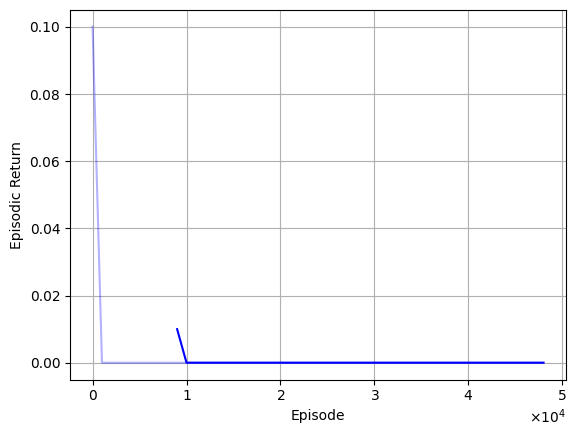

In [240]:
smoothed = pd.Series(agent._rewards).rolling(window=10, center=False).mean()

fig, ax = plt.subplots()

ax.plot(range(0, len(agent._rewards)*1000, 1000), agent._rewards, alpha=0.3, color="blue")
ax.plot(range(0, len(smoothed)*1000, 1000), smoothed, color="blue")

ax.grid()
ax.set_xlabel("Episode")
ax.set_ylabel("Episodic Return")
ax.xaxis.set_major_formatter(ScalarFormatter(useMathText=True))
ax.ticklabel_format(style='sci', axis='x', scilimits=(4, 4))

plt.show()

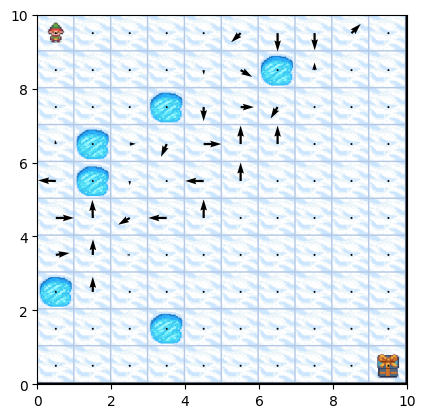

In [241]:
plot_policy(agent.policy)
